In [1]:
import numpy as np
import cv2
import itertools
from itertools import cycle, combinations
import random
from sklearn.utils import shuffle
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from keras.layers import Input, Conv2D, Dense, BatchNormalization, Reshape, MaxPooling2D, Dropout, Flatten, Lambda
from keras.models import Sequential, Model
import keras.backend as K

Using TensorFlow backend.


In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=40, resize=0.5)

y = lfw_people.target
n_samples, image_height, image_width = lfw_people.images.shape
identities = lfw_people.target_names.tolist()
n_identities = len(identities)

# Define model

In [3]:
EMBEDDING_SIZE = 128

def triplet_loss(y_true, y_pred):
    margin = K.constant(1)
    return K.mean(K.maximum(K.constant(0), K.square(y_pred[:,0,0]) - 0.5*(K.square(y_pred[:,1,0]) + K.square(y_pred[:,2,0])) + margin))

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def accuracy(y_true, y_pred):
    return K.mean(y_pred[:,0,0] < y_pred[:,1,0])

input_shape=(image_height, image_width, 1)

input_anchor = Input(shape=input_shape, name='input_anchor')
input_positive = Input(shape=input_shape, name='input_pos')
input_negative = Input(shape=input_shape, name='input_neg')

base_model = Sequential()
base_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
base_model.add(Conv2D(32, (3, 3), activation='relu'))
base_model.add(MaxPooling2D(pool_size=(2, 2)))
base_model.add(Dropout(0.25))

base_model.add(Conv2D(64, (3, 3), activation='relu'))
base_model.add(Conv2D(64, (3, 3), activation='relu'))
base_model.add(MaxPooling2D(pool_size=(2, 2)))
base_model.add(Dropout(0.25))

base_model.add(Flatten())
base_model.add(Dense(256, activation='relu'))
base_model.add(Dropout(0.25))
base_model.add(Dense(EMBEDDING_SIZE, activation='sigmoid'))
base_model.add(BatchNormalization())

net_anchor = base_model(input_anchor)
net_positive = base_model(input_positive)
net_negative = base_model(input_negative)

positive_dist = Lambda(euclidean_distance, name='pos_emb')([net_anchor, net_positive])
negative_dist = Lambda(euclidean_distance, name='neg_emb')([net_anchor, net_negative])
tertiary_dist = Lambda(euclidean_distance, name='ter_emb')([net_positive, net_negative])

stacked_dists = Lambda(lambda vects: K.stack(vects, axis=1), 
                       output_shape=(None, EMBEDDING_SIZE),
                       name='stacked_embs')([positive_dist, negative_dist, tertiary_dist])

model = Model([input_anchor, input_positive, input_negative], stacked_dists, name='triple_siamese')

model.compile(optimizer='adam',
              loss=triplet_loss,
              metrics=[accuracy])

In [4]:
base_model.predict(lfw_people.images[0].reshape((1, image_height, image_width, 1)))

array([[3.3124425e-02, 9.0561604e-01, 3.6879457e-03, 9.1490376e-01,
        9.0644354e-01, 9.9626374e-01, 3.0075100e-01, 6.7711097e-01,
        6.6965567e-03, 4.6070474e-01, 2.4735798e-01, 8.3927143e-01,
        9.1638833e-01, 9.9948591e-01, 6.3326042e-05, 7.3071313e-01,
        9.9945110e-01, 4.3173873e-01, 9.8479128e-01, 9.9686241e-01,
        9.9858159e-01, 5.7859051e-01, 5.7595718e-01, 1.1336742e-03,
        9.3975776e-01, 9.9661881e-01, 5.7316685e-01, 1.8459243e-01,
        9.9797517e-01, 9.9919212e-01, 5.1944070e-02, 5.3292775e-01,
        9.7478366e-01, 9.8869085e-01, 9.7813213e-01, 3.9679058e-02,
        3.8064428e-04, 6.1579710e-01, 9.9889195e-01, 3.3692960e-04,
        3.1836648e-02, 2.3351137e-01, 9.9923086e-01, 9.9531269e-01,
        1.2289649e-01, 6.5927440e-01, 5.1234188e-06, 4.8647180e-01,
        9.2149383e-01, 5.5542266e-01, 8.2136810e-01, 1.2987366e-01,
        9.9930871e-01, 4.9193457e-02, 9.9948627e-01, 7.8103858e-01,
        8.6901076e-02, 9.5579058e-01, 1.5609734e

In [5]:
lfw_people.images[0].shape

(62, 47)

In [6]:
def normalize_scale(x):
    '''Scale grayscale image <0,255> ints to <0,1> floats'''
    return x / 255.0

def transform_img(img_np):
    # TODO: Add image alignment
    return normalize_scale(img_np)

id_images = { id: [] for id in identities }

for i in range(0, lfw_people.images.shape[0]):
    transformed_img = transform_img(lfw_people.images[i])
    identity_id = identities[y[i]]
    id_images[identity_id].append(transformed_img)

In [7]:
id_images['Arnold Schwarzenegger'][0].shape

(62, 47)

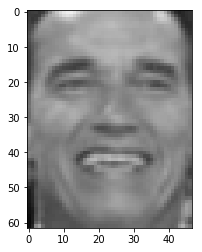

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(id_images['Arnold Schwarzenegger'][1], cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

# Build batches

In [9]:
batches = []

for i in range(0, 40 // 5): # Take 5 out of 40+ images for each identity in each batch
    X_batch = []
    y_batch = []

    for id in identities:
        random.shuffle(id_images[id])
        # Take 5 random images for each identity
        for i in range(0, 5):
            X_batch.append(id_images[id][i].reshape((image_height, image_width, 1)))
            y_batch.append(id)

    batches.append({ 'X': np.array(X_batch), 'y': y_batch })

# Train model

In [10]:
base_model.predict(batches[0]['X']).shape

(95, 128)

In [11]:
batches[0]['y'][0]

'Ariel Sharon'

In [77]:
np.array([0, 1, 0]) == np.array([0, 1, 0])

array([ True,  True,  True])

In [59]:
def get_semihards(batch, embeddings, anchor, pos, identity):
    semihards = []
    for i in range(len(batch['y'])):
        if batch['y'][i] != identity and np.linalg.norm(anchor - pos) > np.linalg.norm(anchor - batch['X'][i]):
            semihards.append(batch['X'][i])
    return np.array(semihards)

def get_positives(batch, identity):
    pos = []
    for i in range(len(batch['y'])):
        if batch['y'][i] == identity:
            pos.append(batch['X'][i])
    return np.array(pos)

def get_triplets(batch, embeddings):
    triplets = [[], [], []]
    for identity in identities:
        pos = get_positives(batch, identity)
        pos_tuples = list(combinations(pos, 2))
        for anchor, pos in pos_tuples:
            semihards = get_semihards(batch, embeddings, anchor, pos, identity)
            for semihard in semihards:
                triplets[0].append(anchor)
                triplets[1].append(pos)
                triplets[2].append(semihard)
    return [np.array(triplets[0]), np.array(triplets[1]), np.array(triplets[2])]


for batch in batches:
    embeddings = base_model.predict(batch['X'])
    triplets = get_triplets(batch, embeddings)
    if len(triplets[0]) > 0:
        model.train_on_batch(triplets, np.zeros(len(triplets[0])))

In [60]:
embeddings = base_model.predict(batches[0]['X'])
triplets = get_triplets(batches[0], embeddings)

In [61]:
triplets[0] = triplets[0][0:100, :, :, :]
triplets[1] = triplets[1][0:100, :, :, :]
triplets[2] = triplets[2][0:100, :, :, :]

In [62]:
model.train_on_batch(triplets, np.zeros(len(triplets[0])))

[1.7667803, 0.61]

# Trained Model Test

In [7]:
import numpy as np

batches, person_list, input_shape = np.load('../data/dataset.npy')

In [8]:
input_shape

(100, 75, 1)

In [11]:
from squeezenet import create_model

cecek_model = create_model(input_shape, 128)

In [12]:
cecek_model.load_weights('../model/facenet_squeezenet_weights.h5')

In [13]:
batches[0]['y'][0], batches[0]['y'][1], batches[0]['y'][5]

('Aaron Peirsol', 'Aaron Peirsol', 'Abdullah')

In [15]:
cecek_a = cecek_model.predict(batches[0]['X'][0].reshape((1, 100, 75, 1))).reshape((128,))
cecek_b = cecek_model.predict(batches[0]['X'][1].reshape((1, 100, 75, 1))).reshape((128,))
np.linalg.norm(cecek_a - cecek_b)

4.109472

In [17]:
cecek_a = cecek_model.predict(batches[0]['X'][0].reshape(((1, 100, 75, 1)))).reshape((128,))
cecek_b = cecek_model.predict(batches[0]['X'][5].reshape((1, 100, 75, 1))).reshape((128,))
np.linalg.norm(cecek_a - cecek_b)

4.9722314

In [19]:
cecek_model.predict(batches[0]['X'][0].reshape((1, 100, 75, 1)))

array([[0.33869407, 0.29226   , 0.19095892, 0.9738616 , 0.09419377,
        0.55241334, 0.2859047 , 0.6532606 , 0.97450984, 0.7114258 ,
        0.9616282 , 0.4089322 , 0.4542818 , 0.42849404, 0.9500675 ,
        0.0104285 , 0.77147245, 0.10771455, 0.69529295, 0.11069614,
        0.69548255, 0.98072815, 0.970315  , 0.03857901, 0.4425099 ,
        0.07026688, 0.17698711, 0.14658111, 0.01358039, 0.38021865,
        0.23545949, 0.23930222, 0.75630075, 0.10261254, 0.3492439 ,
        0.23330936, 0.78441405, 0.77530503, 0.13317382, 0.8489595 ,
        0.8181326 , 0.58240825, 0.21618965, 0.936974  , 0.74585915,
        0.55132765, 0.7809031 , 0.12280788, 0.08387784, 0.03713632,
        0.9897786 , 0.6879033 , 0.1234594 , 0.03015274, 0.8426458 ,
        0.23442101, 0.42806718, 0.08623642, 0.2638505 , 0.35129133,
        0.30554163, 0.41457385, 0.53762645, 0.34881085, 0.86679053,
        0.70767456, 0.33353525, 0.15538171, 0.73793364, 0.91908026,
        0.3093923 , 0.9739832 , 0.1438837 , 0.98

In [1]:
from dataset import load_dataset

batches, person_list, input_shape = load_dataset()

input_shape

(100, 75, 1)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

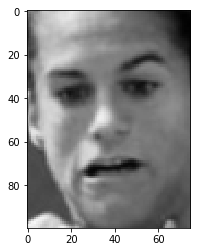

In [18]:
plt.imshow(batches[0]['X'][6].reshape((100, 75)), cmap='gray', vmin=0, vmax=1)
plt.show()

In [6]:
from mobilenetv2 import create_model

base_model = create_model(input_shape, 128)

In [7]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 97, 72, 36)        612       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 36, 36)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 34, 40)        13000     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 17, 40)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 17, 40)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 15, 20)        7220      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 7, 20)         0         
__________

In [8]:
base_model.load_weights('../model/facenet_mobilenetv2_weights.h5')

In [52]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Lambda, concatenate, Input, BatchNormalization, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def fire(x, squeeze=16, expand=64):
    x = Conv2D(squeeze, (1,1), padding='valid')(x)
    x = Activation('relu')(x)

    left = Conv2D(expand, (1,1), padding='valid')(x)
    left = Activation('relu')(left)

    right = Conv2D(expand, (3,3), padding='same')(x)
    right = Activation('relu')(right)

    x = concatenate([left, right], axis=3)
    return x

def create_model(input_shape, embedding_size):
    img_input = Input(input_shape)
    x = Conv2D(64, (5, 5), strides=(2, 2), padding='valid')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = fire(x, squeeze=16, expand=16)
    x = fire(x, squeeze=16, expand=16)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = fire(x, squeeze=32, expand=32)
    x = fire(x, squeeze=32, expand=32)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = fire(x, squeeze=48, expand=48)
    x = fire(x, squeeze=48, expand=48)
    x = fire(x, squeeze=64, expand=64)
    x = fire(x, squeeze=64, expand=64)
    x = Dropout(0.2)(x)
    x = Conv2D(512, (1, 1), padding='same')(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(embedding_size, activation='sigmoid')(x)

    return Model(img_input, out)


squeeze_net = create_model(input_shape, 128)

In [53]:
squeeze_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 100, 75, 1)   0                                            
__________________________________________________________________________________________________
conv2d_165 (Conv2D)             (None, 48, 36, 64)   1664        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 48, 36, 64)   256         conv2d_165[0][0]                 
__________________________________________________________________________________________________
activation_156 (Activation)     (None, 48, 36, 64)   0           batch_normalization_6[0][0]      
__________________________________________________________________________________________________
max_poolin